In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from hydra import initialize, compose
from lenstronomy.Plots import plot_util
from glob import glob

from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import overplot, plot
from mejiro.lenses import test
from mejiro.helpers import pyhalo, lenstronomy_sim, pandeia_input, convert, bkg

In [2]:
lens = test.TutorialLens()
model = lens.get_array(num_pix=45, side=4.95)

In [3]:
noise_list = []

for i in range(10):
    noise_list.append(bkg.get_background())

In [5]:
noise_list = []

for i in range(10):
    calc = build_default_calc('roman', 'wfi', 'imaging')
    calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.

    # set scene size settings
    calc['configuration']['max_scene_size'] = 5

    # set instrument
    calc['configuration']['instrument']['filter'] = 'f106'  # e.g. 'f106'

    # set detector
    calc['configuration']['detector']['ma_table_name'] = 'hlwas_imaging'

    # turn off noise sources
    calc['calculation'] = pandeia_input.get_calculation_dict(init=False)

    # set background
    calc['background'] = bkg.get_background()

    # add an extra point source far out to force maximum scene size
    calc['scene'].append(build_default_source(geometry='point', telescope='roman'))
    calc['scene'][1]['position']['x_offset'] = 100
    calc['scene'][1]['position']['y_offset'] = 100

    image, _ = pandeia_input.get_pandeia_image(calc)
    noise_list.append(image)

Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01


In [6]:
last_array = noise_list[-1]

for i, array in enumerate(noise_list):
    print(np.count_nonzero(last_array - array))

2025
2025
2025
2025
2025
2025
2025
2025
2025
0


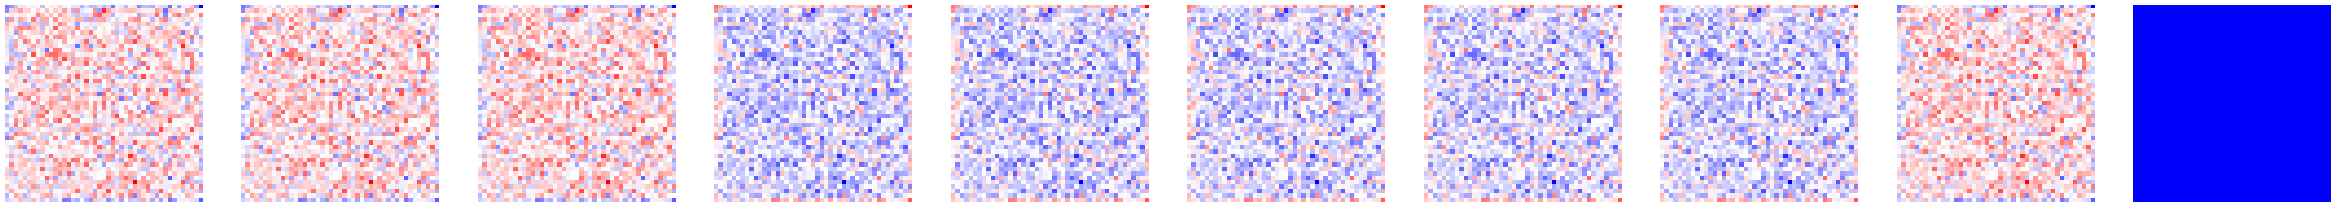

In [9]:
f, ax = plt.subplots(1, len(noise_list), figsize=(30,30))

for i, array in enumerate(noise_list):
    axis = ax[i].imshow(last_array - array, cmap='bwr')  # , norm=norm
    ax[i].set_axis_off()

plt.show()